In [1]:
import xarray as xr

import glob
import os
import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

from dask.distributed import Client, LocalCluster

## Open Cloud Height xarray dataset

In [2]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    chunks={'time': 40785, 'latitude': 3, 'longitude': 3},
    engine='zarr'
)
# When we pass in a chunks argument, the dataset opened will be filled with Dask arrays

/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "latitude" starting at index 3. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/ngoc54n/miniconda3/envs/goesenv/lib/python3.11/site-packages/xarray/core/dataset.py:247: UserWarning: The specified Dask chunks separate the stored chunks along dimension "longitude" starting at index 3. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [3]:
# Longitudes and Latitudes for all the field locations on San Juan Islands
mtdallas = (48.53, -123.13)
cattlepoint = (48.46, -122.96)
falsebay = (48.48, -123.06)
fhl = (48.55, -123.01)

In [4]:
falsebay_timeseries = ds['Height'].sel(latitude = falsebay[0], longitude = falsebay[1], method='nearest')
falsebay_timeseries

<xarray.DataArray 'Height' (time: 40785)>
dask.array<getitem, shape=(40785,), dtype=float32, chunksize=(40785,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 48.48
    longitude  float64 -123.1
  * time       (time) datetime64[ns] 2022-04-30T17:01:17 ... 2022-09-30T16:51:17
Attributes:
    coordinates:   dem_px_angle_y dem_px_angle_x
    grid_mapping:  spatial_ref

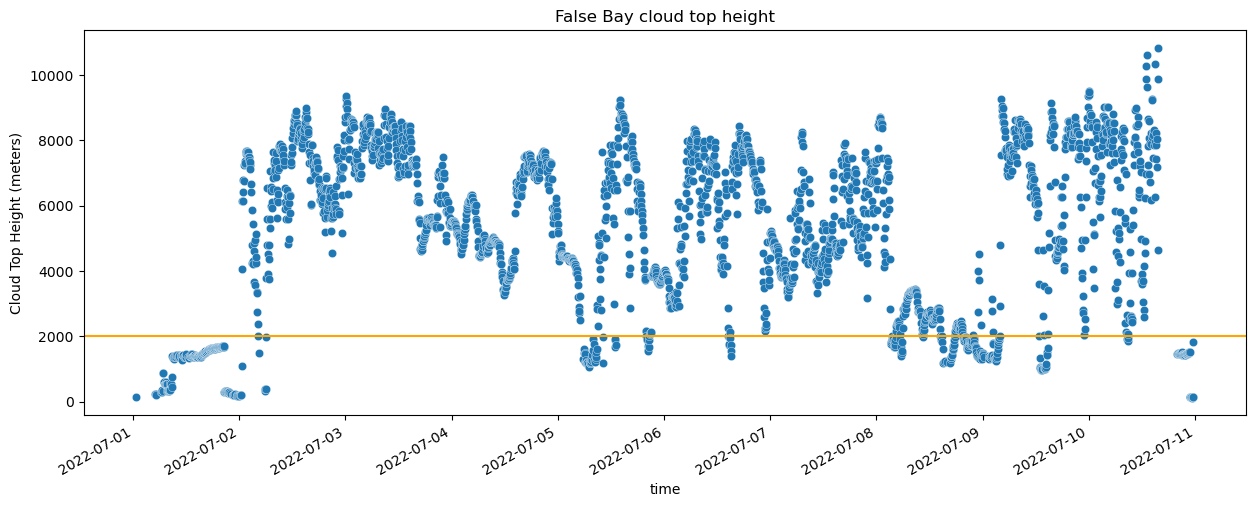

In [5]:
falsebay_timeseries.sel(time = slice('July 1, 2022', 'July 10, 2022')).plot.scatter('time', figsize=(15,5), linewidths=0.25)
plt.title('False Bay cloud top height')
plt.ylabel('Cloud Top Height (meters)')
plt.axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

## Open computer vision fog prediction pandas dataframe

In [60]:
df = pd.read_csv('FalseBay_predicted_time_df.csv', index_col = 0)
df

,Time,Predicted label
0,2022-05-01 06:00:01,1
1,2022-05-01 06:30:01,1
2,2022-05-01 07:00:01,1
3,2022-05-01 07:30:01,1
4,2022-05-01 08:00:01,1
...,...,...
2187,2022-07-18 07:30:01,0
2188,2022-07-18 08:00:01,0
2189,2022-07-18 08:30:01,0
2190,2022-07-18 09:00:01,0


In [37]:
df.shape[0]

2192

In [61]:
# Convert the time values which are currently strings to datetime
df['Time'] = pd.to_datetime(df['Time'])
type(df['Time'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [62]:
fog_df = df.set_index('Time') # can only slice time if time is index

In [65]:
fog_df

,Predicted label
Time,
2022-05-01 06:00:01,1
2022-05-01 06:30:01,1
2022-05-01 07:00:01,1
2022-05-01 07:30:01,1
2022-05-01 08:00:01,1
...,...
2022-07-18 07:30:01,0
2022-07-18 08:00:01,0
2022-07-18 08:30:01,0


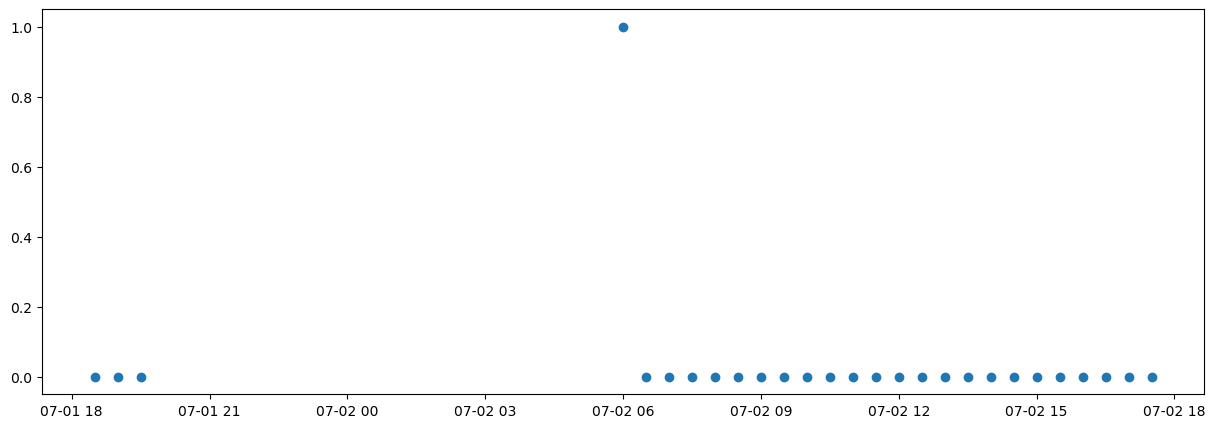

In [64]:
plt.figure(figsize=(15,5))
plt.scatter(fog_df['2022-07-01 18:00:02': '2022-07-02 18:00:00'].index, fog_df['2022-07-01 18:00:02': '2022-07-02 18:00:00']["Predicted label"])
# plt.scatter(time_df[10:30].index, time_df[10:30]["Predicted label"])

## Compare

### Merge the Cloud Height DataArray and Fog Dataframe into one dataframe with the same time column/index

In [13]:
# # Convert Cloud Height into pandas dataframe
# height_df = falsebay_timeseries.to_dataframe()
# # Save in a csv file because converting to dataframe takes a while
# height_df.to_csv('falsebay_cloudheight_df.csv')

In [72]:
''' When loading the dataframe of Cloud Height from in a csv file,
we have to set the time column as index in order to merge it later with the fog classification along the time axis.
datetime after read out from csv are usually strings, so we have to convert them back to datetime objects
'''
height_df = pd.read_csv('falsebay_cloudheight_df.csv', index_col='time', parse_dates=True)
print(type(height_df.index[0]))
height_df 

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,latitude,longitude,Height
time,,,
2022-04-30 17:01:17,48.476114,-123.056412,770.63934
2022-04-30 17:06:17,48.476114,-123.056412,698.91650
2022-04-30 17:11:17,48.476114,-123.056412,NaN
2022-04-30 17:16:17,48.476114,-123.056412,NaN
2022-04-30 17:21:17,48.476114,-123.056412,NaN
...,...,...,...
2022-09-30 16:31:17,48.476114,-123.056412,1886.46410
2022-09-30 16:36:17,48.476114,-123.056412,1928.58230
2022-09-30 16:41:17,48.476114,-123.056412,NaN


In [73]:
fog_df

,Predicted label
Time,
2022-05-01 06:00:01,1
2022-05-01 06:30:01,1
2022-05-01 07:00:01,1
2022-05-01 07:30:01,1
2022-05-01 08:00:01,1
...,...
2022-07-18 07:30:01,0
2022-07-18 08:00:01,0
2022-07-18 08:30:01,0


In [75]:
result = pd.concat([height_df, fog_df], axis=1)
result

,latitude,longitude,Height,Predicted label
2022-04-30 17:01:17,48.476114,-123.056412,770.63934,NaN
2022-04-30 17:06:17,48.476114,-123.056412,698.91650,NaN
2022-04-30 17:11:17,48.476114,-123.056412,NaN,NaN
2022-04-30 17:16:17,48.476114,-123.056412,NaN,NaN
2022-04-30 17:21:17,48.476114,-123.056412,NaN,NaN
...,...,...,...,...
2022-09-30 16:31:17,48.476114,-123.056412,1886.46410,NaN
2022-09-30 16:36:17,48.476114,-123.056412,1928.58230,NaN
2022-09-30 16:41:17,48.476114,-123.056412,NaN,NaN
2022-09-30 16:46:17,48.476114,-123.056412,2023.50060,NaN


In [76]:
result.index

DatetimeIndex(['2022-04-30 17:01:17', '2022-04-30 17:06:17',
               '2022-04-30 17:11:17', '2022-04-30 17:16:17',
               '2022-04-30 17:21:17', '2022-04-30 17:26:17',
               '2022-04-30 17:31:17', '2022-04-30 17:36:17',
               '2022-04-30 17:41:17', '2022-04-30 17:46:17',
               ...
               '2022-09-30 16:06:17', '2022-09-30 16:11:17',
               '2022-09-30 16:16:17', '2022-09-30 16:21:17',
               '2022-09-30 16:26:17', '2022-09-30 16:31:17',
               '2022-09-30 16:36:17', '2022-09-30 16:41:17',
               '2022-09-30 16:46:17', '2022-09-30 16:51:17'],
              dtype='datetime64[ns]', length=42977, freq=None)

In [93]:
df0 = result['2022-07-01 06:00:00':'2022-07-31 11:59:59']
df0["Predicted label"][0]

1.0

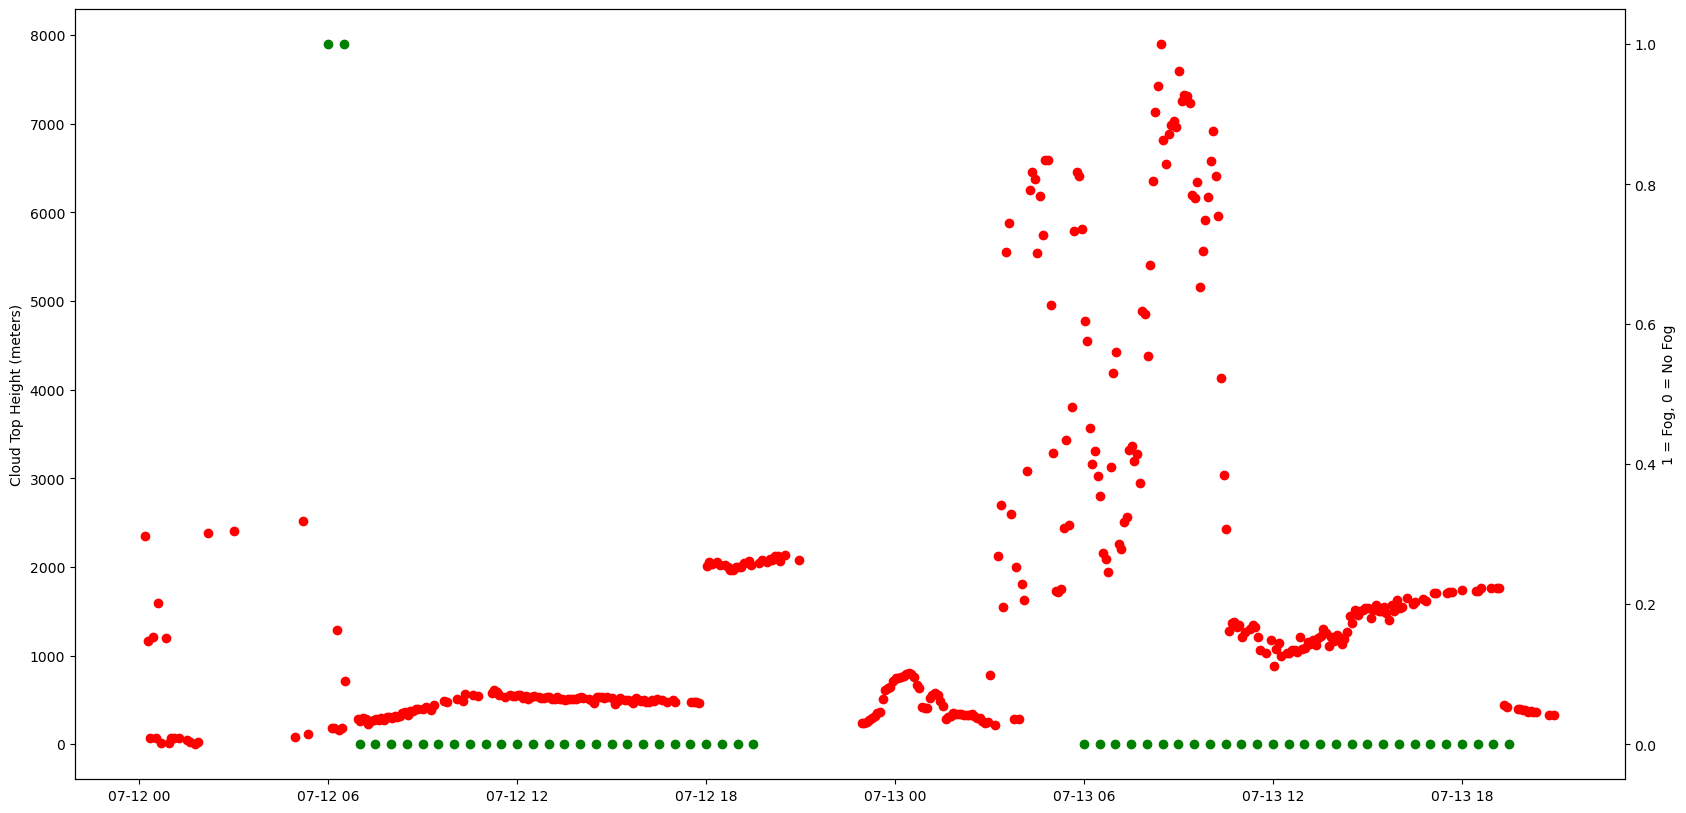

In [87]:
fig, ax1 = plt.subplots(figsize = (20,10))
ax_twin = ax1.twinx()
ax1.set_ylabel("Cloud Top Height (meters)")
ax_twin.set_ylabel("1 = Fog, 0 = No Fog")

df1 = result['2022-07-12 00:05:00': '2022-07-13 21:00:00']
ax1.scatter(df1.index, df1["Height"], color = 'r')
ax_twin.scatter(df1.index, df1["Predicted label"], color = 'g')

# awesome job Autumn! now try Cassie's way to plot the fog/no fog as background vertical lines!

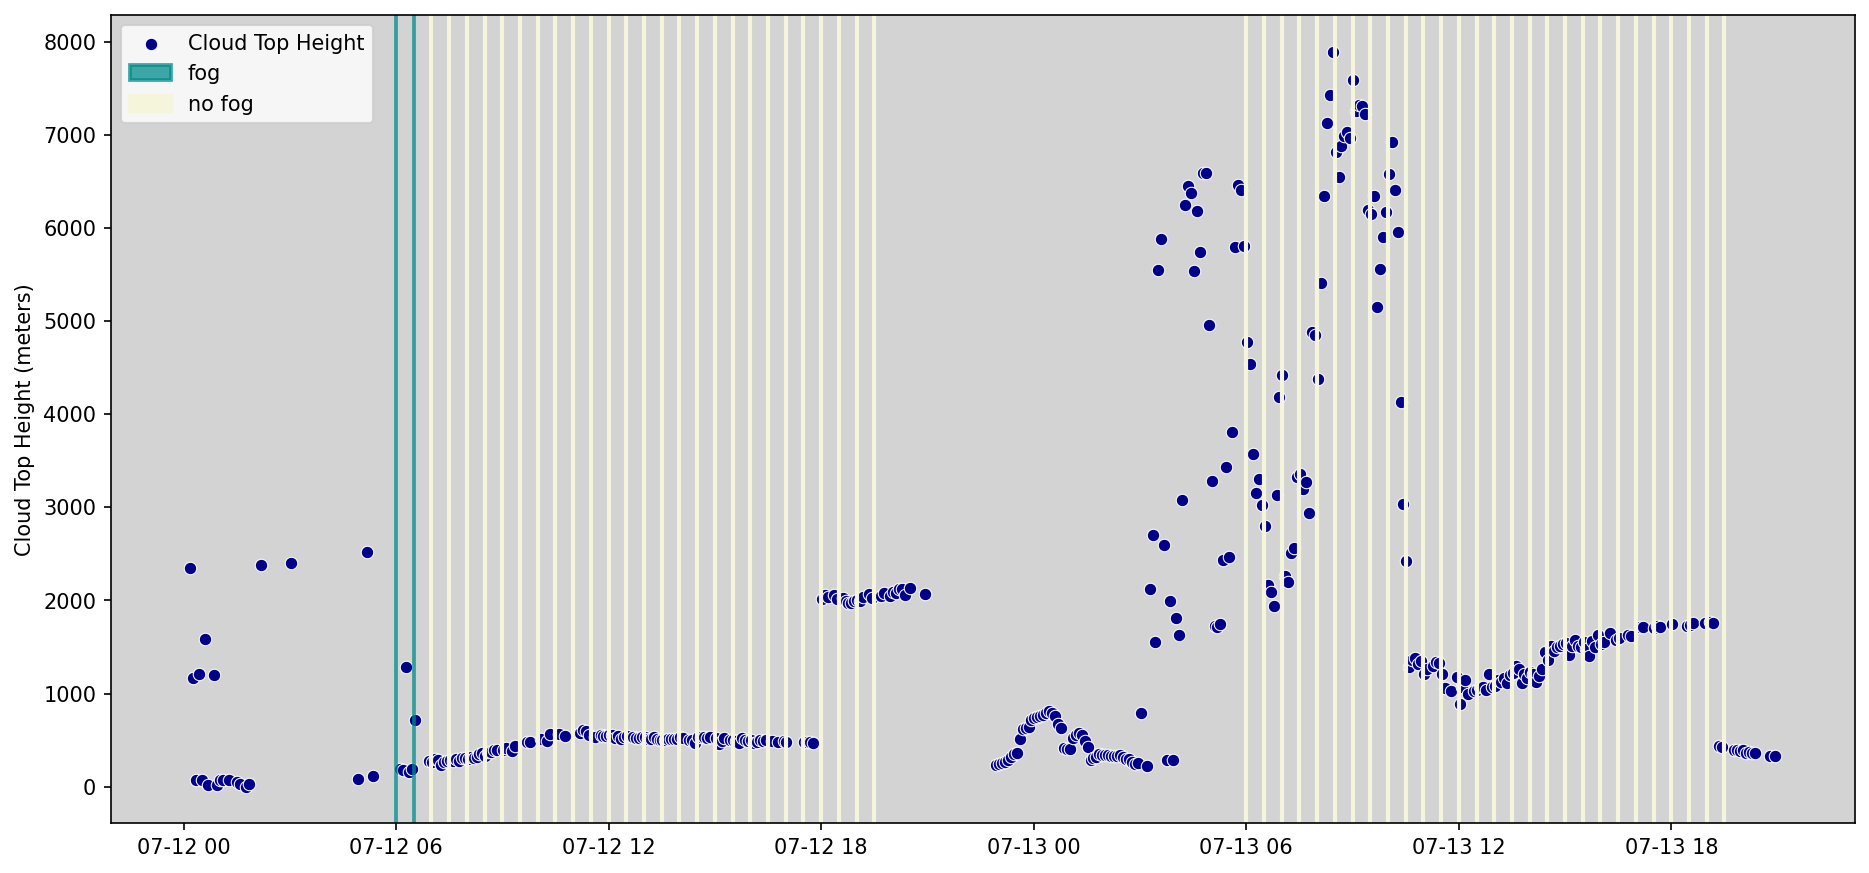

In [137]:
fig, ax1 = plt.subplots(figsize = (15,7), dpi=150)

df1 = result['2022-07-12 00:05:00': '2022-07-13 21:00:00']
# Cloud Height points
ax1.scatter(df1.index, df1["Height"], color='darkblue', linewidths=0.5, edgecolor='white', label="Cloud Top Height")
ax1.set_ylabel("Cloud Top Height (meters)")

ax1.set_facecolor('lightgrey') # background color

no_fog_counter = 1
fog_counter = 1
for i in range(len(df1)):
	if df1["Predicted label"][i] == 0:
		if no_fog_counter == 1: # counter to add the legend for only one line of the many lines that represent no fog
			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2, label='no fog')
			no_fog_counter = 0
		else:
			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2)

	elif df1["Predicted label"][i] == 1:
		if fog_counter == 1: # counter to add the legend for only one line of the many lines that represent fog
			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=1.8, label='fog')
			fog_counter = 0
		else:
			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=1.8)

plt.legend(loc = 'upper left')

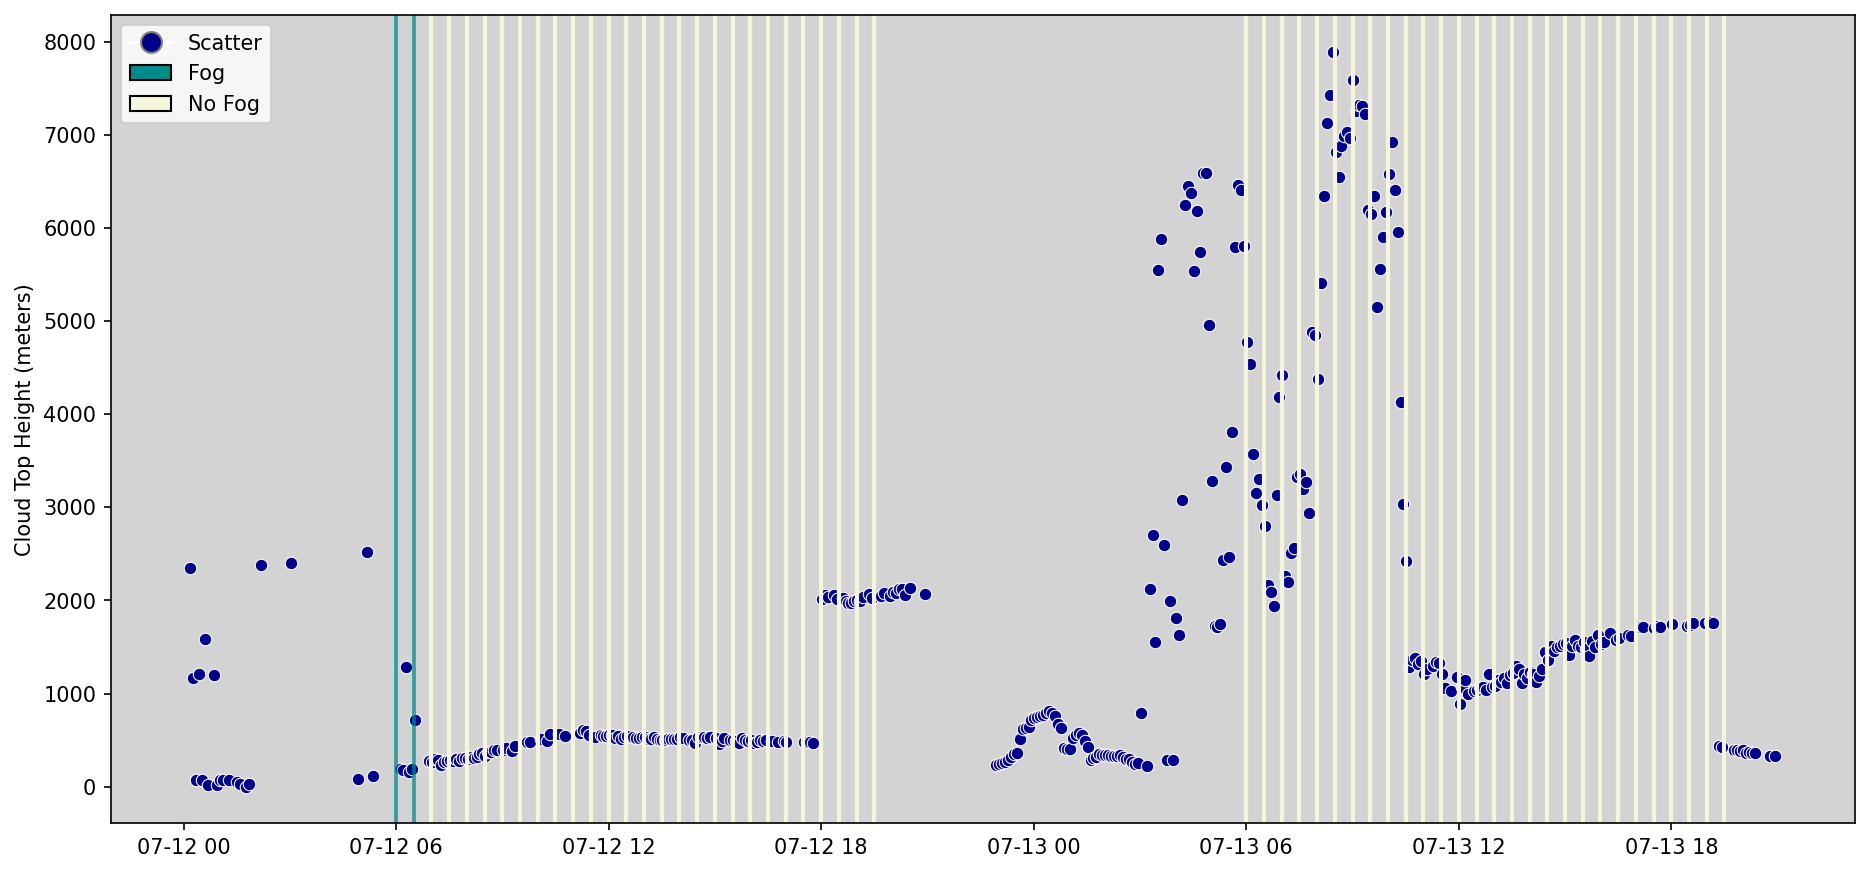

In [158]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax1 = plt.subplots(figsize = (15,7), dpi=150)

df1 = result['2022-07-12 00:05:00': '2022-07-13 21:00:00']
ax1.scatter(df1.index, df1["Height"], color='darkblue', linewidths=0.5, edgecolor='white', label="Cloud Top Height") # Cloud Height points
ax1.set_ylabel("Cloud Top Height (meters)")
ax1.set_facecolor('lightgrey') # background color

for i in range(len(df1)):
	if df1["Predicted label"][i] == 0:
			no_fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='beige', alpha=1, linewidth=2, label='no fog')

	elif df1["Predicted label"][i] == 1:
			fog_line = ax1.axvspan(df1.index[i], df1.index[i], color='darkcyan', alpha=0.75, linewidth=1.8, label='fog')

# Add custom legend (doc: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
legend_elements = [	Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='darkblue', markeredgecolor='grey', markersize=10),
					Patch(facecolor='darkcyan', edgecolor='black', label='Fog'),
					Patch(facecolor='beige', edgecolor='black', label='No Fog')
					]
ax1.legend(handles=legend_elements)

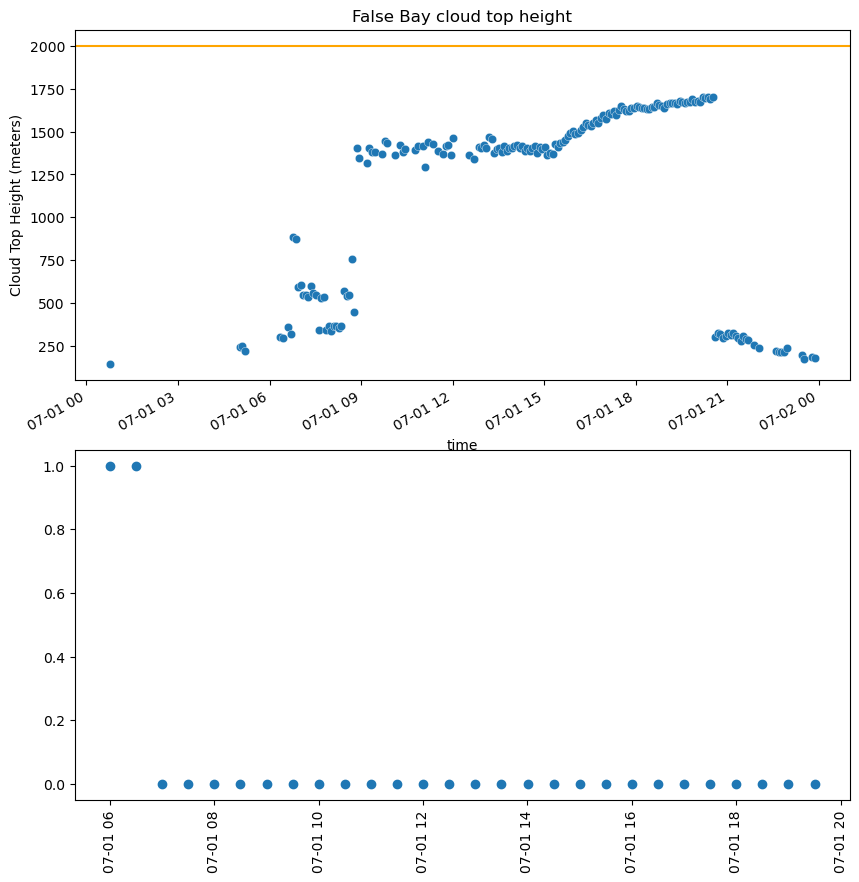

In [84]:
# Old code
fig, ax = plt.subplots(ncols=1, nrows=2, figsize = (10, 10))

falsebay_timeseries.sel(time = slice('July 1, 2022', 'July 1, 2022')).plot.scatter('time', linewidths=0.25, ax = ax[0])
ax[0].set_title('False Bay cloud top height')
ax[0].set_ylabel('Cloud Top Height (meters)')
ax[0].axhline(2000, color='orange') # 2000 meters is the chosen threshold for low cloud and fog

test_df = fog_df['2022-07-01': '2022-07-01']
# fig.autofmt_xdate()
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].locator_params(axis='x', nbins=10)
ax[1].scatter(test_df.index, test_df['Predicted label'])